## **CIFAR10 image classification**

### **1. Functionalize the code**

- **Load the dataset**
- **Preprocess the data**
- **Resize the images+Data augmentation**
- **Build the model : Transfer learning(Xception)**



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import random as python_random
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import cifar10
import cv2
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.applications import VGG16, ResNet50V2, Xception
from tensorflow.keras.models import Model

def set_random_seed(seed_value):
  np.random.seed(seed_value)
  python_random.seed(seed_value)
  tf.random.set_seed(seed_value)

def data_preprocessing(x, y, scaling=True):
  if scaling: 
    x = np.array(x/255.0, dtype=np.float32)
  else:
    x = np.array(x, dtype=np.float32)
  y = np.array(y, dtype=np.float32)
  return x, y

def data_one_hot_ecoding(x, y):
  x, y = data_preprocessing(x, y, scaling=False)
  y_ohe = to_categorical(y)
  return x, y_ohe

def get_train_valid_test_set(train_x, train_y, test_x, test_y, valid_size=0.15, random_state=42):
  train_x, train_y_ohe = data_one_hot_ecoding(train_x, train_y)
  test_x, test_y_ohe = data_one_hot_ecoding(test_x, test_y)
  tr_x, val_x, tr_y_ohe, val_y_ohe = train_test_split(train_x, train_y_ohe, test_size=valid_size, random_state=random_state)
  return (tr_x, tr_y_ohe), (val_x, val_y_ohe), (test_x, test_y_ohe)

def get_resized_images(x, resize=64):
  x_cnt = x.shape[0]
  x_resized = np.zeros((x.shape[0], resize, resize, 3))
  for i in range(x_cnt):
    x_resize = cv2.resize(x[i], (resize, resize))
    x_resized[i] = x_resize
  return x_resized

def create_model(model_name='option'):
  input_tensor = Input(shape=(x_size, x_size, 3))
  if model_name == 'VGG16':
    base_model = VGG16(input_tensor=input_tensor, include_top=False, weights='imagenet')
  elif model_name == 'ResNet50V2':
    base_model = ResNet50V2(input_tensor=input_tensor, include_top=False, weights='imagenet')
  elif model_name == 'Xception':
    base_model = Xception(input_tensor=input_tensor, include_top=False, weights='imagenet')
  base_model_out = base_model.output
  x = GlobalAveragePooling2D()(base_model_out)
  if model_name != 'VGG16':
    x = Dropout(0.5)(x)
  x = Dense(50, activation='relu')(x)
  output = Dense(10, activation='softmax')(x)
  model_customed = Model(inputs=input_tensor, outputs=output)
  model_customed.summary()
  return model_customed

In [ ]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

x_size = 32
b_size = 32

def show_results(x_size=x_size, model_name='option'):
  set_random_seed(42)
  (train_x, train_y), (test_x, test_y) = cifar10.load_data()
  print(f'load_data : {train_x.shape, train_y.shape, test_x.shape, test_y.shape}')
  (tr_x, tr_y_ohe), (val_x, val_y_ohe), (ts_x, ts_y_ohe) = \
  get_train_valid_test_set(train_x, train_y, test_x, test_y, valid_size=0.15, random_state=42)
  print(f'get_train_valid_test_set : {tr_x.shape, tr_y_ohe.shape, val_x.shape, val_y_ohe.shape, ts_x.shape, ts_y_ohe.shape}')

  if x_size > 32:
    tr_x = get_resized_images(tr_x)
    val_x = get_resized_images(val_x)
    ts_x = get_resized_images(ts_x)
    print(f'get_resized_images : {tr_x.shape, val_x.shape, ts_x.shape}')
  
  tr_generator = ImageDataGenerator(horizontal_flip=True, rescale=1/255.0)
  val_generator = ImageDataGenerator(rescale=1/255.0)
  ts_generator = ImageDataGenerator(rescale=1/255.0)
  tr_generator_flow = tr_generator.flow(tr_x, tr_y_ohe, batch_size=b_size, shuffle=True)
  val_generator_flow = tr_generator.flow(val_x, val_y_ohe, batch_size=b_size, shuffle=False)
  ts_generator_flow = tr_generator.flow(ts_x, ts_y_ohe, batch_size=b_size, shuffle=False)

  model_selected = create_model(model_name)
  model_selected.summary()
  model_selected.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])
  cb_rlr = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=10, factor=0.2, verbose=1)
  cb_esp = EarlyStopping(monitor='val_loss', mode='min', patience=15, verbose=1)
  history = model_selected.fit(tr_generator_flow, validation_data=val_generator_flow, epochs=50, callbacks=[cb_rlr, cb_esp])
  evaluation = model_selected.evaluate(ts_generator_flow)
  return history, evaluation

In [ ]:
history, evaluation = show_results(x_size=64, model_name='Xception')

170508288/170498071 [==============================] - 6s 0us/step
load_data : ((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1))
get_train_valid_test_set : ((42500, 32, 32, 3), (42500, 10), (7500, 32, 32, 3), (7500, 10), (10000, 32, 32, 3), (10000, 10))
get_resized_images : ((42500, 64, 64, 3), (7500, 64, 64, 3), (10000, 64, 64, 3))
83697664/83683744 [==============================] - 2s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 15, 15, 32)   864         ['input_1[0][0]']                
                                                                           

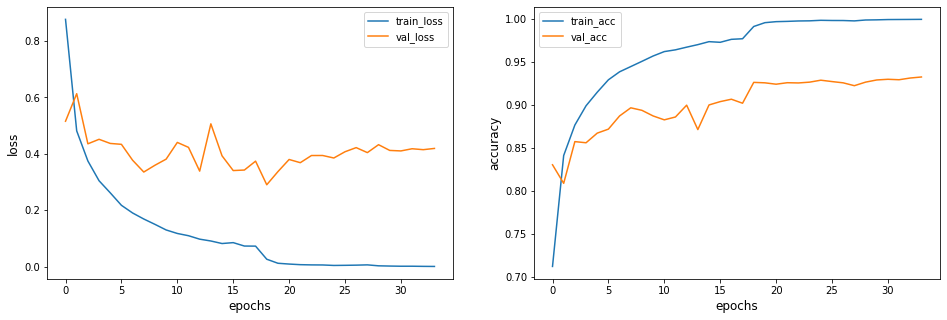

In [ ]:
def show_history(history):
  fig, axs = plt.subplots(figsize=(16, 5), nrows=1, ncols=2)
  axs[0].plot(history.history['loss'], label='train_loss')
  axs[0].plot(history.history['val_loss'], label='val_loss')

  axs[1].plot(history.history['accuracy'], label='train_acc')
  axs[1].plot(history.history['val_accuracy'], label='val_acc')

  axs[0].legend()
  axs[0].set_xlabel('epochs', fontsize=12)
  axs[0].set_ylabel('loss', fontsize=12)

  axs[1].legend()
  axs[1].set_xlabel('epochs', fontsize=12)
  axs[1].set_ylabel('accuracy', fontsize=12)
  plt.show()

show_history(history)

### **2. Evaluate the model**

In [ ]:
print(f'evaluation result : {evaluation}')

evaluation result : [0.4458117187023163, 0.930899977684021]
